## Model Training

Please ensure that you have python version greater or equal to 3.10 and less than or equal to 3.11. The newest version of Deepchem does not support python 3.12 yet.

In [1]:
# assert that python version is >=3.10 and <=3.11
import sys
assert sys.version_info >= (3, 10) and sys.version_info <= (3, 11) , "Python version not supported. Please use version 3.10 or 3.11"

Install the required packages

In [2]:
!pip install -r requirements.txt
!pip install tensorflow==2.15.0 # For some reason, installing tensorflow from requirements.txt sometimes doesn't have cuda support.


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Import libs

Ensure tensorflow is the correct version and has GPU support. Note that tensorflow is pinned to 2.15.0 due to compatibility issues with Deepchem.

In [1]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2024-06-17 15:53:20.708749: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 15:53:20.730098: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 15:53:20.730120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 15:53:20.730688: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 15:53:20.734597: I tensorflow/core/platform/cpu_feature_guar

2.15.0


2024-06-17 15:53:21.827258: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-17 15:53:21.846249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-17 15:53:21.846285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-17 15:53:21.980246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-17 15:53:21.980281: I external/local_xla/xla/stream_executor

'/device:GPU:0'

In [1]:
import deepchem as dc # requires python3<=3.11, numpy<2.0.0, tensorflow==2.15.0
dc.__version__

Skipped loading some Pytorch utilities, missing a dependency. No module named 'torch'
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


This module requires PyTorch to be installed.


2024-06-17 15:54:42.168538: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-17 15:54:42.190128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 15:54:42.190151: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 15:54:42.190766: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 15:54:42.194807: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


'2.8.1.dev'

You can build the training dataset yourself, or you can load the pre-built version from file. If you would like to load the pre-built dataset, feel free to ignore the next few cells.

In [3]:
dataset_file = 'datasets/train_set_no_oversampling.csv'
task = ['Biodegradation']
featurizer_func = dc.feat.ConvMolFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='smiles', featurizer=featurizer_func)
dataset = loader.create_dataset(dataset_file)

Balance the dataset using Deepchem `BalancingTransformer`.

In [4]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
balanced_dataset = transformer.transform(dataset)

Save to disk

In [5]:
dc.utils.save_to_disk(balanced_dataset, 'prebuilt_datasets/balanced_dataset.joblib')

Alternatively, you can just run this to load the pre-built dataset from file.

In [2]:
balanced_dataset = dc.utils.load_from_disk('prebuilt_datasets/balanced_dataset.joblib')

Use the GraphConvModel from Deepchem with 0.2 dropout. Note that all checkpoints will be saved in the models directory.

In [32]:
model = dc.models.GraphConvModel(n_tasks=1, mode='classification', dropout=0.2, graph_conv_layers=[128 ,128], dense_layer_size=128)

In [18]:
model.loss

In [33]:
model.fit(balanced_dataset, nb_epoch=100)

0.16216991424560548

Run the following cell to build the test set, or skip it and load the pre-built test set directly from file.

In [28]:
test_set = 'datasets/test_set.csv'
featurizer_func = dc.feat.ConvMolFeaturizer()
task = ['Biodegradation']

loader = dc.data.CSVLoader(feature_field='smiles', featurizer=featurizer_func, tasks=task)
test_dataset = loader.create_dataset(test_set)

dc.utils.save_to_disk(test_dataset, 'prebuilt_datasets/test_dataset.joblib')

Load the test dataset

In [29]:
test_dataset = dc.utils.load_from_disk('prebuilt_datasets/test_dataset.joblib')

Evaluate the model on the test set.

In [34]:
model.evaluate(test_dataset, [dc.metrics.Metric(dc.metrics.roc_auc_score), dc.metrics.Metric(dc.metrics.matthews_corrcoef), dc.metrics.Metric(dc.metrics.recall_score) ])

{'roc_auc_score': 0.9160690303518668,
 'matthews_corrcoef': 0.6472172956325212,
 'recall_score': 0.9041095890410958}

Predict using new smiles strings.

In [35]:
def predict_smiles(smiles: str):
    featurizer_func = dc.feat.ConvMolFeaturizer()
    featured_smiles = featurizer_func.featurize([smiles])
    result = model.predict_on_batch(featured_smiles)[0][0]
    
    return {
        'Biodegradable Probability': result[1],
        'Not biodegradable Probability': result[0]
    }


predict_smiles('OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)F')

{'Biodegradable Probability': 0.0001791798,
 'Not biodegradable Probability': 0.9998209}

In [23]:
import numpy as np

# load csv file
import pandas as pd
df = pd.read_csv('datasets/test_set.csv')

# get the smiles column
smiles = df['smiles']
biodegration = df['Biodegradation']

In [16]:
smiles

0                      CCCCCCCCCCCCCCO
1                    O=C(O)/C=C/C(=O)O
2                CC(C)COc1ccc2ccccc2c1
3                            OCc1cncs1
4                   C=C(C)C(=O)OCC(C)C
                    ...               
554                     COc1ccc(OC)cc1
555    CCCCCCCCCCCCCCC(CO)CCCCCCCCCCCC
556           Nc1ccc2[nH]c(=O)[nH]c2c1
557          CC(C)Nc1ccc(Nc2ccccc2)cc1
558          COc1c2occc2cc2ccc(=O)oc12
Name: smiles, Length: 559, dtype: object

In [36]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, recall_score, confusion_matrix

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)


def sensitivity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp+fn)


y_true = biodegration
y_pred = []

for smile in smiles:
    result = predict_smiles(smile)
    y_pred.append(result['Biodegradable Probability'])
    
roc, mcc, rec, sp, sn = roc_auc_score(y_true, y_pred), matthews_corrcoef(y_true, np.round(y_pred)), recall_score(y_true, np.round(y_pred)), specificity_score(y_true, np.round(y_pred)) , sensitivity_score(y_true, np.round(y_pred))


print(f'ROC AUC: {roc}')
print(f'Matthews Correlation Coefficient: {mcc}')
print(f'Recall: {rec}')
print(f'Specificity: {sp}')
print(f'Sensitivity: {sn}')


ROC AUC: 0.9160623153370937
Matthews Correlation Coefficient: 0.6472172956325212
Recall: 0.9041095890410958
Specificity: 0.7588235294117647
Sensitivity: 0.9041095890410958


In [56]:
!pip install seaborn matplotlib

<Axes: >

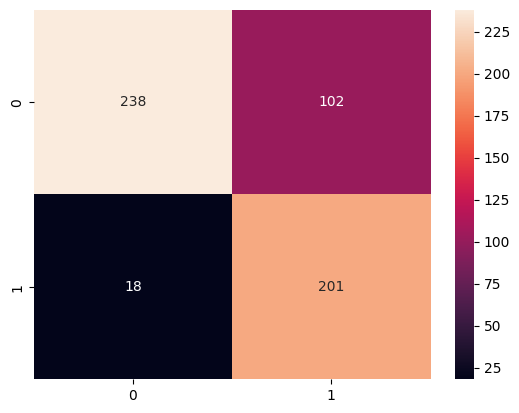

In [31]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, np.round(y_pred))
sns.heatmap(cm, annot=True, fmt='d')

## Hyperparameter tuning via Ray Tune

In [ ]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import deepchem as dc


class DeepChemTrainable(tune.Trainable):
    def setup(self, config):
        self.config = config
        self.model = dc.models.GraphConvModel(n_tasks=1, mode='classification', 
                                              dropout=config['dropout'], 
                                              graph_conv_layers=config['graph_conv_layers'], 
                                              dense_layer_size=config['dense_layer_size'])
        self.model.fit(balanced_dataset, nb_epoch=config['nb_epoch'])

    def step(self):
        result = self.model.evaluate(test_dataset, [dc.metrics.Metric(dc.metrics.roc_auc_score), 
                                                    dc.metrics.Metric(dc.metrics.matthews_corrcoef), 
                                                    dc.metrics.Metric(dc.metrics.recall_score) ])
        return {"roc_auc": result['roc_auc_score'], 
                "mcc": result['matthews_corrcoef'], 
                "recall": result['recall_score']}

search_space = {
    "nb_epoch": tune.grid_search([50, 70]),
    "graph_conv_layers": tune.grid_search([[32, 32], [64, 64], [128, 128]]),
    "dense_layer_size": tune.grid_search([128, 256, 512]),
    "dropout": tune.grid_search([0.0, 0.1, 0.2])
}

analysis = tune.run(
    DeepChemTrainable,
    resources_per_trial={"cpu": 20, "gpu": 1},
    config=search_space,
    scheduler=ASHAScheduler(metric="roc_auc", mode="max"),
    num_samples=1
)


In [38]:
analysis.dataframe()

,roc_auc,mcc,recall,done,training_iteration,trial_id,date,timestamp,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/nb_epoch,config/graph_conv_layers,config/dense_layer_size,config/dropout,logdir
0,0.913323,0.659435,0.821918,True,100,eb6db_00000,2024-06-17_12-16-42,1718641002,0.040612,5.080467,206250,HPGD,172.27.21.110,5.080467,100,50,"[32, 32]",128,0.0,eb6db_00000


In [23]:
df = analysis.dataframe()

In [24]:
df.to_csv('tune_results.csv')

In [35]:
analysis.get_best_config(metric='mcc', mode='max')

{'nb_epoch': 70,
 'graph_conv_layers': [32, 32],
 'dense_layer_size': 128,
 'dropout': 0.0}

In [ ]:
BEST_CONFIG = {'nb_epoch': 70, 'graph_conv_layers': [32, 32], 'dense_layer_size': 128, 'dropout': 0.0}

In [45]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import deepchem as dc


class DeepChemTrainable(tune.Trainable):
    def setup(self, config):
        self.config = config
        self.model = dc.models.GraphConvModel(n_tasks=1, mode='classification', 
                                              dropout=config['dropout'], 
                                              graph_conv_layers=config['graph_conv_layers'], 
                                              dense_layer_size=config['dense_layer_size'])
        self.model.fit(dataset, nb_epoch=config['nb_epoch'])

    def step(self):
        result = self.model.evaluate(test_dataset, [dc.metrics.Metric(dc.metrics.roc_auc_score), 
                                                    dc.metrics.Metric(dc.metrics.matthews_corrcoef), 
                                                    dc.metrics.Metric(dc.metrics.recall_score) ])
        return {"roc_auc": result['roc_auc_score'], 
                "mcc": result['matthews_corrcoef'], 
                "recall": result['recall_score']}

search_space = {
    "nb_epoch": tune.grid_search([50]),
    "graph_conv_layers": tune.grid_search([[64, 64], [128, 128]]),
    "dense_layer_size": tune.grid_search([128]),
    "dropout": tune.grid_search([0.2])
}

analysis_rerun = tune.run(
    DeepChemTrainable,
    resources_per_trial={"cpu": 20, "gpu": 1},
    config=search_space,
    scheduler=ASHAScheduler(metric="roc_auc", mode="max"),
    num_samples=1
)


2024-06-17 12:30:35,220	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,mcc,recall,roc_auc
DeepChemTrainable_ec59d_00000,0.64887,0.872146,0.916747
DeepChemTrainable_ec59d_00001,0.671947,0.899543,0.913806


2024-06-17 12:31:25,843	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/matcha/ray_results/DeepChemTrainable_2024-06-17_12-30-35' in 0.0018s.
2024-06-17 12:31:25,847	INFO tune.py:1041 -- Total run time: 50.63 seconds (50.61 seconds for the tuning loop).


In [40]:
analysis_rerun.dataframe()

,roc_auc,mcc,recall,done,training_iteration,trial_id,date,timestamp,time_this_iter_s,time_total_s,pid,hostname,node_ip,time_since_restore,iterations_since_restore,config/nb_epoch,config/graph_conv_layers,config/dense_layer_size,config/dropout,logdir
0,0.907887,0.623477,0.762557,True,100,67166_00000,2024-06-17_12-20-15,1718641215,0.039772,4.718146,209007,HPGD,172.27.21.110,4.718146,100,70,"[32, 32]",128,0.0,67166_00000
1,0.902340,0.652433,0.799087,True,1,67166_00001,2024-06-17_12-20-52,1718641252,0.791312,0.791312,210209,HPGD,172.27.21.110,0.791312,1,70,"[32, 32, 32]",128,0.0,67166_00001
2,0.902659,0.621439,0.794521,True,1,67166_00002,2024-06-17_12-21-27,1718641287,0.499276,0.499276,211040,HPGD,172.27.21.110,0.499276,1,90,"[32, 32]",128,0.0,67166_00002
3,0.901027,0.645636,0.799087,True,1,67166_00003,2024-06-17_12-22-14,1718641334,0.793676,0.793676,211927,HPGD,172.27.21.110,0.793676,1,90,"[32, 32, 32]",128,0.0,67166_00003
4,0.877488,0.624949,0.840183,True,1,67166_00004,2024-06-17_12-22-54,1718641374,0.640228,0.640228,212927,HPGD,172.27.21.110,0.640228,1,100,"[32, 32]",128,0.0,67166_00004
5,0.907165,0.666776,0.803653,True,4,67166_00005,2024-06-17_12-23-44,1718641424,0.049588,0.844438,213890,HPGD,172.27.21.110,0.844438,4,100,"[32, 32, 32]",128,0.0,67166_00005
